In [9]:
import os
import nibabel as nib
import numpy as np
import nilearn
from nilearn import image
import pandas as pd
from hampel import hampel
import scipy.stats as stats
import matplotlib.pyplot as plt

In [10]:
# data_dir = '/arc/project/st-ipor-1/mkhademi/BOLD5000_2.0/'
# output_dir = '/scratch/st-ipor-1/mkhademi/'
output_dir = 'C:\\Users\\mahkh\\Documents\\'
roi_dir = output_dir + 'image_data\\parcels\\'
subjs = ['CSI1', 'CSI2', 'CSI3', 'CSI4']
roi_names =['lFFA','rFFA','lOFA','rOFA','lSTS','rSTS','lLOC','rLOC','lPPA','rPPA','lRSC','rRSC','lTOS','rTOS','lEBA','rEBA']
roi_voxels = {'lFFA': 531, 'rFFA': 1019, 'lOFA': 211, 'rOFA': 790, 'lSTS': 844, 'rSTS': 2505, 'lLOC': 4971, 'rLOC': 5085,
             'lPPA': 732, 'rPPA': 553, 'lRSC': 1063, 'rRSC': 1741, 'lTOS': 133, 'rTOS': 251, 'lEBA': 2155, 'rEBA': 2413}

In [11]:
sub = subjs[0]
#sub = 'all'
j = 90 # face
dif = nib.load(output_dir + 'image_data\\vis\\dif-' + sub + '-c' + str(j) + '.nii.gz') 
dif = nilearn.image.resample_img(dif, target_shape=(79, 95, 69), target_affine=dif.affine)
dif = np.array(dif.dataobj)
#dif = dif[6:91-6, 7:109-7, 11:91-11]
dif_rois = []
no_roi = np.ones((79, 95, 69), dtype=np.uint8)
for roi_name in roi_names:
    roi = nib.load(roi_dir + roi_name + '.img')
    roi = np.array(roi.dataobj)
    no_roi[np.nonzero(roi)] = 0
    tmp = dif[np.nonzero(roi)]
    tmp[tmp == 0.0] = np.nan
    dif_rois.append(np.nanmedian(tmp))

C:\Users\mahkh\anaconda3\lib\site-packages\numpy\lib\nanfunctions.py:1119: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,


In [12]:
dif_rois = np.array(dif_rois)
tmp = dif[np.nonzero(no_roi)]
tmp[tmp == 0.0] = np.nan
print('rest' + ':', np.round(np.nanmedian(tmp), 8)) 
for i, roi_name in enumerate(roi_names): 
    print(roi_name + ':', np.round(dif_rois[i], 8))

rest: -0.00079246
lFFA: 0.00139239
rFFA: -0.00160833
lOFA: 0.0025602
rOFA: 0.00271917
lSTS: -0.00198917
rSTS: -0.00497076
lLOC: -0.00032066
rLOC: -0.00072202
lPPA: 0.00039756
rPPA: 0.00025593
lRSC: 2.883e-05
rRSC: -0.001782
lTOS: -0.00177655
rTOS: nan
lEBA: 0.00049257
rEBA: 0.01279607


In [13]:
def get_prop(ig_type):
    igs = nib.load(output_dir + 'image_data\\vis\\' + ig_type + '-' + sub + '-c' + str(j) + '.nii.gz') 
    igs = nilearn.image.resample_img(igs, target_shape=(79, 95, 69), target_affine=igs.affine)
    igs = np.array(igs.dataobj)
    #igs = igs[6:91-6, 7:109-7, 11:91-11]

    tmp = igs.reshape(-1)
    tmp[tmp == 0.0] = np.nan
    tmp = tmp[~np.isnan(tmp)]
    p_pos = np.nanpercentile(tmp, 90)
    print("p_90", p_pos)
    p_neg = np.nanpercentile(tmp, 10)
    print("p_10", p_neg)

    igs_rois = []
    all_prop_pos = []
    all_prop_neg = []
    no_roi = np.ones((79, 95, 69), dtype=np.uint8)
    for roi_name in roi_names:
        roi = nib.load(roi_dir + roi_name + '.img')
        roi = np.array(roi.dataobj)
        no_roi[np.nonzero(roi)] = 0
        tmp = igs[np.nonzero(roi)].copy()
        tmp[tmp == 0.0] = np.nan
        tmp = tmp[~np.isnan(tmp)]
        igs_rois.append(np.nanmedian(tmp))
        prop = 0.0
        for x in tmp:
            if x >= p_pos:
                prop += 1
        if len(tmp) > 0:
            all_prop_pos.append(prop/len(tmp))
        else:
            all_prop_pos.append(0.0)
        prop = 0.0
        for x in tmp:
            if x <= p_neg:
                prop += 1
        if len(tmp) > 0:
            all_prop_neg.append(prop/len(tmp))
        else: 
            all_prop_neg.append(0.0)
    igs_rois = np.array(igs_rois)   
    tmp = igs[np.nonzero(no_roi)].copy()
    tmp[tmp == 0.0] = np.nan
    ##
    prop = 0.0
    for x in tmp:
        if x > p_pos:
            prop += 1
    all_prop_pos.append(prop/len(tmp))
    ##
    print('\n')
    ##
    prop = 0.0
    for x in tmp:
        if x < p_neg:
            prop += 1
    all_prop_neg.append(prop/len(tmp))
    ##
    print('\nMedian IGs:')   
    print('rest' + ':', np.round(np.nanmedian(tmp), 8))
    for i, roi_name in enumerate(roi_names): 
        print(roi_name + ':', np.round(igs_rois[i], 8))
    return all_prop_pos, all_prop_neg

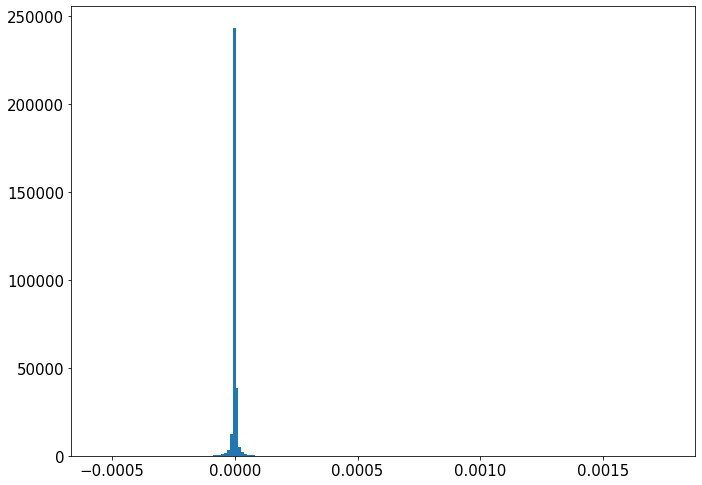

In [14]:
igs = nib.load(output_dir + 'image_data/vis/igs-' + sub + '-c' + str(j) + '.nii.gz') 
igs = nilearn.image.resample_img(igs, target_shape=(79, 95, 69), target_affine=igs.affine)
igs = np.array(igs.dataobj)
#igs = igs[6:91-6, 7:109-7, 11:91-11]

tmp = igs.reshape(-1)
tmp[tmp == 0.0] = np.nan
tmp = tmp[~np.isnan(tmp)]
fig, axs = plt.subplots(1, 1, figsize =(10, 7), tight_layout = True)
axs.hist(tmp, bins=200)
# Show plot
plt.show()

In [15]:
def plot_igs(x, t, y):
    fig = plt.figure()
    fig.set_size_inches(12, 6)
    plt.rc('font', size=15)
    ax = fig.add_axes([0,0,1,1])
    ax.set_ylabel(y)
    ax.set_xlabel('Brain ROIs')
    ax.set_title(sub + ': Face ' + t)
    ax.bar(roi_names+['rest'], x)
    plt.show()

p_90 4.82638552057324e-06
p_10 -5.521188541024458e-06



Median IGs:
rest: -0.0
lFFA: 4e-08
rFFA: 0.0
lOFA: -0.0
rOFA: -0.0
lSTS: -1.22e-06
rSTS: -0.0
lLOC: 0.0
rLOC: -0.0
lPPA: -8.1e-07
rPPA: -2.2e-07
lRSC: -9.4e-07
rRSC: 3e-07
lTOS: 2.8e-07
rTOS: -0.0
lEBA: 3.5e-07
rEBA: -0.0


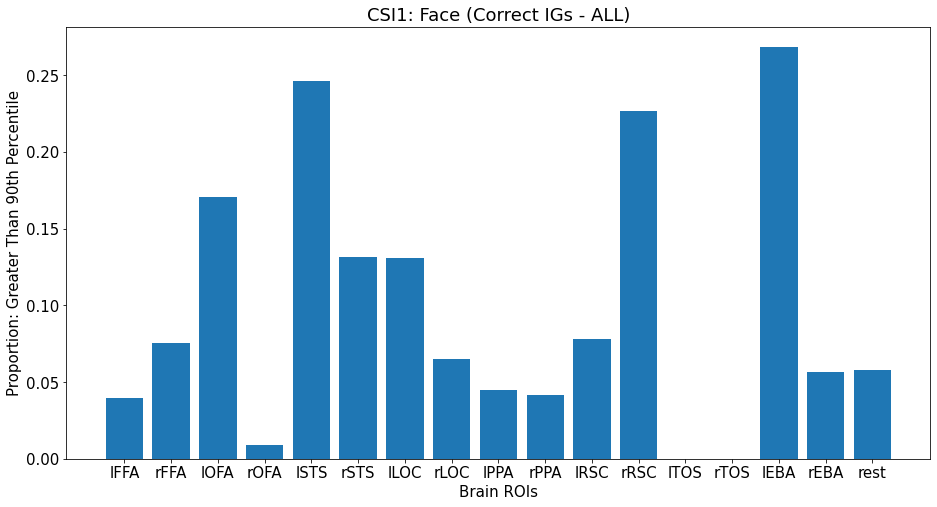

p_90 1.0584379924694077e-05
p_10 -1.117664469347801e-05



Median IGs:
rest: -0.0
lFFA: 3.7e-07
rFFA: 0.0
lOFA: -0.0
rOFA: -0.0
lSTS: -1.95e-06
rSTS: -0.0
lLOC: 1e-08
rLOC: -0.0
lPPA: -1.06e-06
rPPA: -4.3e-07
lRSC: -1.63e-06
rRSC: 2.8e-07
lTOS: 3.4e-07
rTOS: -0.0
lEBA: 7.8e-07
rEBA: -0.0


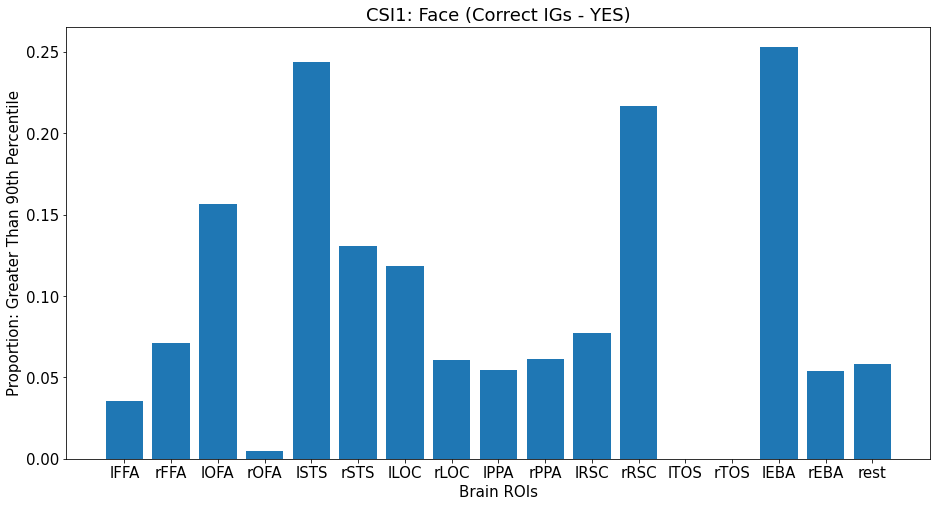

p_90 3.3914441701199472e-06
p_10 -4.107108998141484e-06



Median IGs:
rest: -0.0
lFFA: -3e-08
rFFA: 0.0
lOFA: 0.0
rOFA: -0.0
lSTS: -1.1e-06
rSTS: -0.0
lLOC: 0.0
rLOC: -0.0
lPPA: -5.5e-07
rPPA: -1.6e-07
lRSC: -8.8e-07
rRSC: 1e-07
lTOS: 2.5e-07
rTOS: -0.0
lEBA: 1.7e-07
rEBA: -0.0


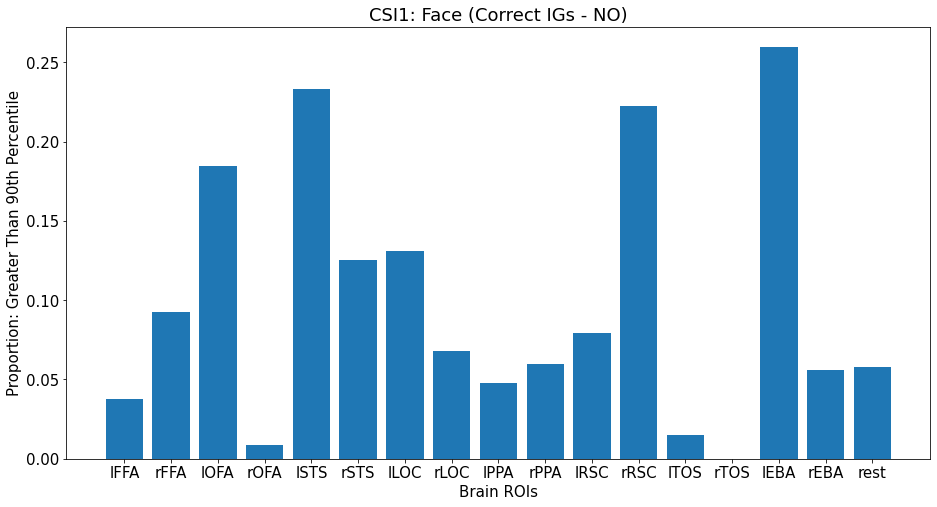

In [16]:
all_prop_pos, all_prop_neg = get_prop(ig_type='igs')
plot_igs(all_prop_pos, '(Correct IGs - ALL)', 'Proportion: Greater Than 90th Percentile')
#plot_igs(all_prop_neg, '(All Correct IGs)', 'Proportion: Less Than 10th Percentile')
all_prop_pos, all_prop_neg = get_prop(ig_type='igs-p')
plot_igs(all_prop_pos, '(Correct IGs - YES)', 'Proportion: Greater Than 90th Percentile')
#plot_igs(all_prop_neg, '(YES Correct IGs)', 'Proportion: Less Than 10th Percentile')
all_prop_pos, all_prop_neg = get_prop(ig_type='igs-n')
plot_igs(all_prop_pos, '(Correct IGs - NO)', 'Proportion: Greater Than 90th Percentile')
#plot_igs(all_prop_neg, '(NO Correct IGs)', 'Proportion: Less Than 10th Percentile')
